In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
from src.efficient_kan import KAN

/root/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn.functional as F
from tqdm import tqdm

In [4]:
import numpy as np
import random

In [5]:
config = {}
config['input_dim'] = 1024*16
config['batch_size'] = 64
config['hidden_layers'] = [1024, 64]
config['lr'] = 1e-3
config['period'] = 2

In [6]:
class kae_dataset(Dataset):
    def __init__(self, num_data=100, input_dim=128):
        super(kae_dataset, self).__init__()
        self.num_data = num_data
        self.target = []
        for i in range(num_data):
            scale = random.random()
            phase_left = random.random() + 0.1
            phase_right = random.random() + 0.1
            x=np.arange(-phase_left*2*np.pi*config['period'],phase_right*2*np.pi*config['period'],(phase_right*2*np.pi+phase_left*2*np.pi)*config['period']/input_dim)
            x=x.reshape(len(x),1)
            y=scale * np.sin(x)
            self.target.append(y)

    def __getitem__(self, index):
        target = torch.from_numpy(self.target[index]).squeeze().unsqueeze(0).to(torch.float32)
        return target

    def __len__(self):
        return len(self.target)

trainset = kae_dataset(10000, config['input_dim'])
valset = kae_dataset(100, config['input_dim'])
trainloader = DataLoader(trainset, batch_size=config['batch_size'], shuffle=True)
valloader = DataLoader(valset, batch_size=config['batch_size'], shuffle=False)

In [7]:
class KVAE(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        input_dim,
    ):
        super(KVAE, self).__init__()
        self.layers_hidden = layers_hidden
        self.input_dim = input_dim
        self.encoder = KAN([input_dim, layers_hidden[0], layers_hidden[1]])
        self.encode_miu = KAN([layers_hidden[1], layers_hidden[1]])
        self.encode_sigma = KAN([layers_hidden[1], layers_hidden[1]])
        self.decoder = KAN([layers_hidden[1], layers_hidden[0], input_dim])

    def encode(self, input):
        posterior_dist = self.encoder(input)

        # Split the result into miu and sigma components
        # of the latent Gaussian distribution
        miu = self.encode_miu(posterior_dist)
        log_sigma = self.encode_sigma(posterior_dist)

        return [miu, log_sigma]

    def decode(self, z):
        priori_dist = self.decoder(z)
        return priori_dist

    def reparameterize(self, miu, log_sigma):
        std = torch.exp(0.5 * log_sigma)
        eps = torch.randn_like(std)
        return eps * std + miu

    def forward(self, input, **kwargs):
        miu, log_sigma = self.encode(input)
        z = self.reparameterize(miu, log_sigma)
        return  [self.decode(z), miu, log_sigma]

    def loss_function(self,
                      input, 
                      ouput, 
                      miu, 
                      log_sigma):

        recons_loss =F.mse_loss(input, ouput)


        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_sigma - miu ** 2 - log_sigma.exp(), dim = 1), dim = 0)

        loss = recons_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss.detach(), 'KLD':-kld_loss.detach()}

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs):
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.layers_hidden[1])

        z = z.to(current_device)

        samples = self.decode(z)
        return samples


In [8]:
# Define model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = KVAE(layers_hidden=config['hidden_layers'], input_dim=config['input_dim'])
model.to(device)
# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=1e-4)
# Define learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

# Define loss
criterion = nn.MSELoss()

In [9]:
for epoch in range(10):
    # Train
    model.train()
    with tqdm(trainloader) as pbar:
        for i, targets in enumerate(pbar):
            targets = targets.view(-1, config['input_dim']).to(device)
            optimizer.zero_grad()
            output, miu, log_sigma = model(targets)
            loss = model.loss_function(output, targets, miu, log_sigma)
            loss['loss'].backward()
            optimizer.step()
            pbar.set_postfix(loss=loss['loss'].item(), lr=optimizer.param_groups[0]['lr'])

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for targets in valloader:
            targets = targets.view(-1, config['input_dim']).to(device)
            output, miu, log_sigma = model(targets)
            loss = model.loss_function(output, targets, miu, log_sigma)
            val_loss += loss['loss'].item()
            
    val_loss /= len(valloader)

    # Update learning rate
    scheduler.step()

    print(
        f"Epoch {epoch + 1}, Val Loss: {val_loss}"
    )

100%|██████████| 157/157 [00:08<00:00, 18.08it/s, loss=0.00154, lr=0.001] 


Epoch 1, Val Loss: 0.0011073964706156403


100%|██████████| 157/157 [00:08<00:00, 18.98it/s, loss=0.000309, lr=0.0008]


Epoch 2, Val Loss: 0.0005717778112739325


100%|██████████| 157/157 [00:08<00:00, 19.44it/s, loss=0.000239, lr=0.00064]


Epoch 3, Val Loss: 0.00027430037152953446


100%|██████████| 157/157 [00:08<00:00, 19.11it/s, loss=0.000156, lr=0.000512]


Epoch 4, Val Loss: 0.0001067442681232933


100%|██████████| 157/157 [00:08<00:00, 18.99it/s, loss=6.01e-5, lr=0.00041] 


Epoch 5, Val Loss: 0.00010158933946513571


100%|██████████| 157/157 [00:08<00:00, 19.07it/s, loss=7.13e-5, lr=0.000328]


Epoch 6, Val Loss: 6.440696961362846e-05


100%|██████████| 157/157 [00:08<00:00, 18.86it/s, loss=4.6e-5, lr=0.000262] 


Epoch 7, Val Loss: 5.151488585397601e-05


100%|██████████| 157/157 [00:08<00:00, 19.17it/s, loss=5.18e-5, lr=0.00021]


Epoch 8, Val Loss: 3.763430140679702e-05


100%|██████████| 157/157 [00:08<00:00, 19.07it/s, loss=3.46e-5, lr=0.000168]


Epoch 9, Val Loss: 3.25449163938174e-05


100%|██████████| 157/157 [00:08<00:00, 18.96it/s, loss=3.64e-5, lr=0.000134]

Epoch 10, Val Loss: 2.9150834961910732e-05


In [10]:
pred = model(valset[0].to(device))[0].detach().cpu().numpy()[0]

In [11]:
import matplotlib.pyplot as plt

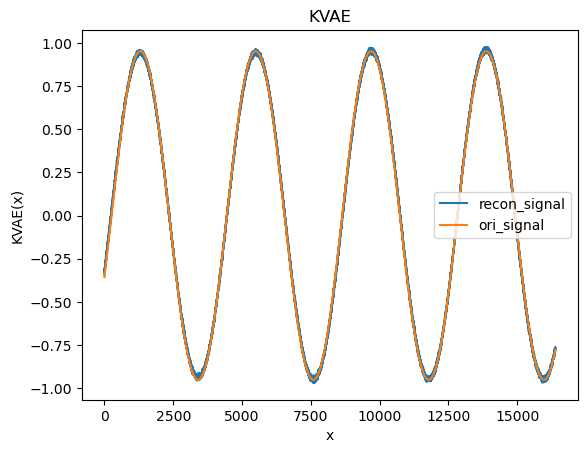

In [12]:
x = np.linspace(0, config['input_dim'], config['input_dim'])
plt.plot(x, pred, label='recon_signal')
plt.plot(x, valset[0][0], label='ori_signal')
plt.xlabel('x')
plt.ylabel('KVAE(x)')
plt.title('KVAE')
plt.legend()
plt.savefig('assets/recon_signal.jpg')
plt.show()

In [13]:
priori_dist0, priori_dist1 = model.encode(valset[0].to(device)), model.encode(valset[1].to(device))
mix_latent = model.reparameterize(priori_dist0[0], priori_dist0[1])/2 + model.reparameterize(priori_dist1[0], priori_dist1[1])/2
mixed_signal = model.decode(mix_latent).detach().cpu().numpy()[0]
signal0 = model(valset[0].to(device))[0].detach().cpu().numpy()[0]
signal1 = model(valset[2].to(device))[0].detach().cpu().numpy()[0]

In [14]:
signal1.shape, signal0.shape, mixed_signal.shape, model.decode(mix_latent).shape

((16384,), (16384,), (16384,), torch.Size([1, 16384]))

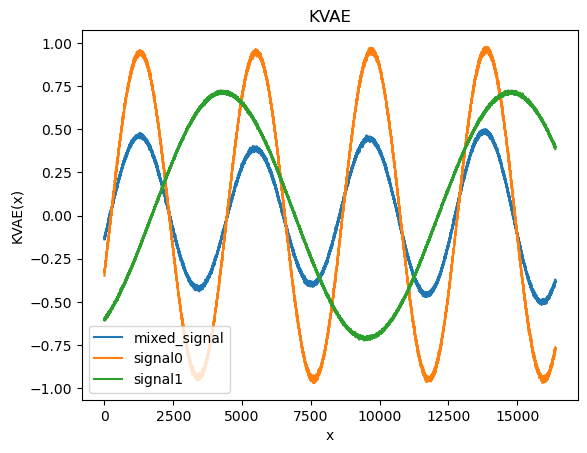

In [18]:
x = np.linspace(0, config['input_dim'], config['input_dim'])
plt.plot(x, mixed_signal, label='mixed_signal')
plt.plot(x, signal0, label='signal0')
plt.plot(x, signal1, label='signal1')
plt.xlabel('x')
plt.ylabel('KVAE(x)')
plt.title('KVAE')
plt.legend()
plt.savefig('assets/mix_signal.jpg')
plt.show()

In [24]:
random_sample = model.sample(1, device).detach().cpu().numpy()

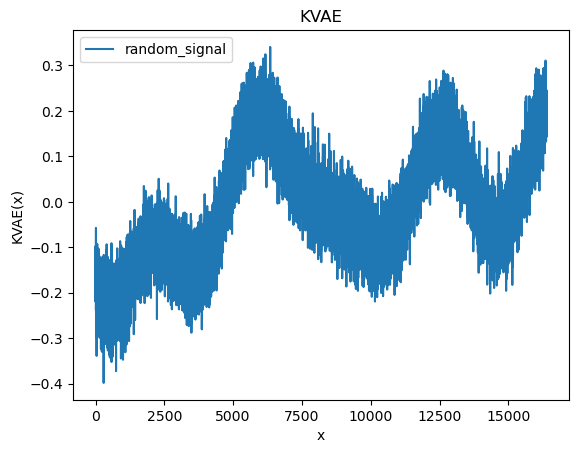

In [25]:
x = np.linspace(0, config['input_dim'], config['input_dim'])
plt.plot(x, random_sample[0], label='random_signal')
plt.xlabel('x')
plt.ylabel('KVAE(x)')
plt.title('KVAE')
plt.legend()
plt.savefig('assets/random_signal.jpg')
plt.show()